In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, Callback
import psutil
import time
import GPUtil
import matplotlib.pyplot as plt

In [2]:
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "../dataset/seg_train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"   
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "../dataset/seg_test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"   
)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [4]:
def get_cpu_ram():
    cpu_percent = psutil.cpu_percent(interval=1)
    ram = psutil.virtual_memory()
    ram_used_mb = ram.used / (1024 ** 2)
    return cpu_percent, ram_used_mb
def get_gpu_stats():

    try:
        gpus = GPUtil.getGPUs()
        if not gpus:
            return None, None, None
        gpu = gpus[0]
        return gpu.load * 100, gpu.memoryUsed, gpu.memoryTotal
    except:
        return None, None, None


In [5]:
cpu_before, ram_before = get_cpu_ram()
gpu_before, vram_used_before, vram_total_before = get_gpu_stats()

msg = f"AVANT entraînement → CPU: {cpu_before:.1f}% | RAM: {ram_before:.0f} MB"
if gpu_before is not None:
    msg += f" | GPU: {gpu_before:.1f}% | VRAM: {vram_used_before}/{vram_total_before} MB"
print(msg)


AVANT entraînement → CPU: 3.4% | RAM: 14949 MB | GPU: 45.0% | VRAM: 627.0/16303.0 MB


In [6]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  

In [7]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(6, activation="softmax")
])

In [8]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)


In [9]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

class PerformanceCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        cpu, ram = get_cpu_ram()
        gpu, vram_used, vram_total = get_gpu_stats()
        duration = time.time() - self.start_time

        msg = f" | CPU: {cpu:.1f}% | RAM: {ram:.0f} MB | Time: {duration:.1f}s"
        if gpu is not None:
            msg += f" | GPU: {gpu:.1f}% | VRAM: {vram_used}/{vram_total} MB"
        print(msg)



In [10]:
print("TensorFlow version:", tf.__version__)
print("GPUs disponibles :", tf.config.list_physical_devices("GPU"))

TensorFlow version: 2.10.1
GPUs disponibles : []


In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, PerformanceCallback()]
)


Epoch 1/10
439/439 [==============================] - 97s 219ms/step - loss: 0.7979 - accuracy: 0.6930 - val_loss: 0.6240 - val_accuracy: 0.7620
Epoch 2/10
439/439 [==============================] - 94s 215ms/step - loss: 0.6109 - accuracy: 0.7706 - val_loss: 0.5946 - val_accuracy: 0.7743
Epoch 3/10
439/439 [==============================] - 96s 218ms/step - loss: 0.5691 - accuracy: 0.7841 - val_loss: 0.5698 - val_accuracy: 0.7853
Epoch 4/10
439/439 [==============================] - 95s 217ms/step - loss: 0.5396 - accuracy: 0.7931 - val_loss: 0.5906 - val_accuracy: 0.7797
Epoch 5/10
439/439 [==============================] - 94s 214ms/step - loss: 0.5166 - accuracy: 0.8035 - val_loss: 0.5606 - val_accuracy: 0.7920
Epoch 6/10
439/439 [==============================] - 96s 219ms/step - loss: 0.4909 - accuracy: 0.8124 - val_loss: 0.5559 - val_accuracy: 0.7903
Epoch 7/10
439/439 [==============================] - 99s 226ms/step - loss: 0.4749 - accuracy: 0.8195 - val_loss: 0.5587 - val_ac

In [12]:
cpu_after, ram_after = get_cpu_ram()
gpu_after, vram_used_after, vram_total_after = get_gpu_stats()

msg = f"APRÈS entraînement → CPU: {cpu_after:.1f}% | RAM: {ram_after:.0f} MB"
if gpu_after is not None:
    msg += f" | GPU: {gpu_after:.1f}% | VRAM: {vram_used_after}/{vram_total_after} MB"
print(msg)


APRÈS entraînement → CPU: 4.4% | RAM: 16465 MB | GPU: 1.0% | VRAM: 953.0/16303.0 MB


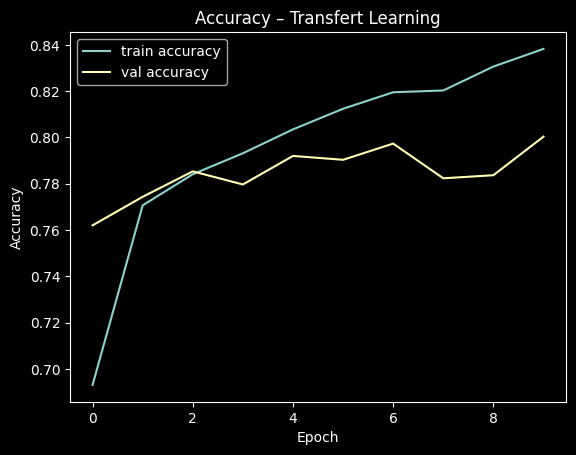

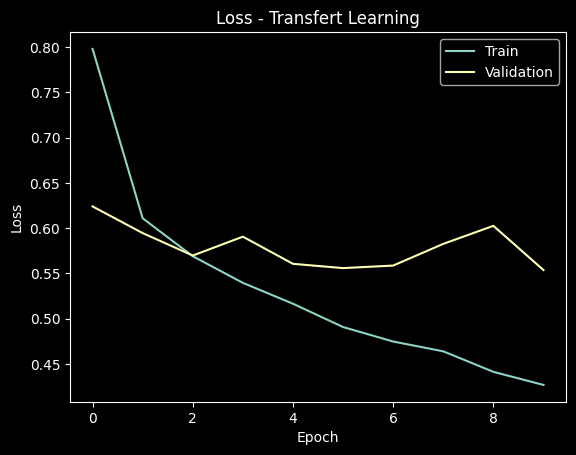

In [13]:
plt.figure()
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy – Transfert Learning")
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.title("Loss - Transfert Learning")
plt.show()

### Conclusion 
L’entraînement en transfer learning sur ce dernier dataset montre une progression régulière des performances, avec une précision de validation maximale d’environ 80,0 % atteinte à l’epoch 10. La perte de validation diminue globalement pour se stabiliser autour de 0,55, ce qui traduit une généralisation correcte, malgré de légères fluctuations et un début de surapprentissage en fin d’entraînement.

L’utilisation des ressources matérielles reste globalement maîtrisée. Le CPU est peu sollicité (environ 1 à 7 %), la RAM reste stable entre 15 et 16,5 Go, et la VRAM utilisée demeure inférieure à 1 Go. Le GPU est faiblement exploité sur ce jeu de données, tandis que le temps d’entraînement par epoch est élevé (≈ 95 à 100 secondes), principalement dû à la taille du dataset et au modèle pré-entraîné.